In [1]:
!pip install numba
#


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from PIL import Image
from hashlib import sha256
from numba import njit


In [3]:
np.random.seed(42)  # or any fixed seed value
iv = np.random.randint(0, 256, size=16, dtype=np.uint8)
prev_cipher = iv.copy()


In [5]:
plainImg = r"C:\Users\User\Desktop\Images\color Image\512x512\Baboon.png"

##  Optimized Chaotic Sequence Generator with Numba

In [6]:
def aes_g(word, round_idx, sbox, Rcon):
    # Rotate left
    word = word[1:] + word[:1]
    # Apply S-box
    word = [sbox[b // 16][b % 16] for b in word]
    # XOR with round constant
    word[0] ^= Rcon[round_idx]
    return word

def key_expansion(key, sbox, Rcon): 
    w = []
    for i in range(4):
        w.append(key[4*i : 4*(i+1)])  # initial 4 words from 16-byte key

    for i in range(4, 44):  # total 44 words for AES-128 (11 rounds × 4 words)
        temp = w[i - 1]
        if i % 4 == 0:
            temp = aes_g(temp, i // 4, sbox, Rcon)
        w.append([w[i - 4][j] ^ temp[j] for j in range(4)])
    return w


In [7]:
def logistic_map_sequence(length, x0=0.5, r=3.99, discard=100):
    """
    Generate a logistic map sequence of given length with optional discard.
    """
    x = x0
    seq = []
    for i in range(length + discard):
        x = r * x * (1 - x)
        if i >= discard:
            seq.append(x)
    return np.array(seq)


In [8]:
@njit
def logistic_tent_map_fast(x, r):
    if x < 0.5:
        return (r * x * (1 - x) + (4 - r) * x / 2) % 1
    else:
        return (r * x * (1 - x) + (4 - r) * (1 - x) / 2) % 1

@njit
def henon_map_sequence(x0=0.1, y0=0.1, a=1.4, b=0.3, length=256):
    """
    Generate a 1D chaotic sequence from a 2D Henon map.
    The output is a float array in [0, 1) scaled from x_n values.
    """
    x, y = x0, y0
    seq = []
    for _ in range(length):
        x_new = 1 - a * x**2 + y
        y_new = b * x
        x, y = x_new, y_new
        # Normalize x to [0, 1)
        seq.append(abs(x % 1))
    return np.array(seq)



In [9]:
def chaotic_xor_mask_feedback(flat_array, x0=0.5, r=3.99):
    """
    Apply feedback-based chaotic XOR masking using logistic map.
    Each byte is XORed with the chaotic value and the previous masked byte.
    """
    chaotic_seq = logistic_map_sequence(len(flat_array), x0, r)
    chaotic_bytes = (chaotic_seq * 256).astype(np.uint8)

    masked = np.zeros_like(flat_array)
    masked[0] = flat_array[0] ^ chaotic_bytes[0]
    for i in range(1, len(flat_array)):
        masked[i] = flat_array[i] ^ chaotic_bytes[i] ^ masked[i - 1]

    return masked, chaotic_bytes


In [10]:
def generate_shift_pattern_deterministic(seed: float, r: float, block_index: int):
    """
    Generate a deterministic 4-element shift pattern based on block index.
    Ensures reproducibility for encryption and decryption.
    """
    x0 = (seed + block_index * 0.0001) % 1  # vary slightly with block index
    pattern = []
    x = x0
    for _ in range(4):
        x = r * x * (1 - x)
        pattern.append(x)
    pattern = np.argsort(pattern).tolist()
    # print("pattern",pattern)
    return pattern


In [11]:
def chaotic_pixel_permutation(flat_array, x0=0.75, r=3.99):
    length = len(flat_array)
    x = x0
    seq = np.zeros(length)
    for i in range(length):
        x = r * x * (1 - x)
        seq[i] = x
    permutation = np.argsort(seq)
    # print(permutation,seq,len(seq),len(flat_array))
    return flat_array[permutation], permutation


## Fast Variable S-box Generator

In [12]:
def generate_variable_sbox_henon(x0=0.1, y0=0.1, a=1.4, b=0.3):
    """
    Generate a variable S-box using a 2D Henon chaotic map.
    """
    seq = henon_map_sequence(x0, y0, a, b, length=256)
    indices = np.argsort(seq)
    sbox = indices.reshape((16, 16))
    return sbox, (x0 + 0.01) % 1, (y0 + 0.01) % 1  # evolve seeds


## AES Core Functions (ShiftRows, MixColumns, AddRoundKey)

In [13]:
def shift_rows_variable(state, shift_pattern):
    """
    Shift each row of the AES state matrix by the amount specified in shift_pattern.

    Args:
        state: 4x4 AES state matrix.
        shift_pattern: List of 4 integers specifying the number of positions to shift each row.

    Returns:
        A new state matrix with rows shifted accordingly.
    """
    return [
        state[row][shift_pattern[row]:] + state[row][:shift_pattern[row]]
        for row in range(4)
    ]


def mix_columns(state):
    def gmul(a, b):
        p = 0
        for _ in range(8):
            if b & 1: p ^= a
            high_bit = a & 0x80
            a = (a << 1) & 0xFF
            if high_bit: a ^= 0x1B
            b >>= 1
        return p
    result = [[0]*4 for _ in range(4)]
    for c in range(4):
        result[0][c] = gmul(0x02, state[0][c]) ^ gmul(0x03, state[1][c]) ^ state[2][c] ^ state[3][c]
        result[1][c] = state[0][c] ^ gmul(0x02, state[1][c]) ^ gmul(0x03, state[2][c]) ^ state[3][c]
        result[2][c] = state[0][c] ^ state[1][c] ^ gmul(0x02, state[2][c]) ^ gmul(0x03, state[3][c])
        result[3][c] = gmul(0x03, state[0][c]) ^ state[1][c] ^ state[2][c] ^ gmul(0x02, state[3][c])
    return result

def add_round_key(state, round_key):
    return [[state[row][col] ^ round_key[row][col] for col in range(4)] for row in range(4)]

def word_list_to_matrix(words):
    assert len(words) == 4 and all(len(w) == 4 for w in words), "Expected 4x4 matrix"
    return [[words[row][col] for col in range(4)] for row in range(4)]


In [14]:
def aes_encrypt_block(plain_block, key, sbox,shift_pattern):
    Rcon = [0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36]
    round_keys = key_expansion(key, sbox, Rcon)

    # Convert to 4x4 state matrix
    state = [plain_block[i:i+4] for i in range(0, 16, 4)]

    # Initial AddRoundKey
    state = add_round_key(state, word_list_to_matrix(round_keys[0:4]))

    # Rounds 1 to 9
    for round in range(1, 10):
        state = [[sbox[byte // 16][byte % 16] for byte in row] for row in state]  # SubBytes
        state = shift_rows_variable(state, shift_pattern)

        state = mix_columns(state)
        state = add_round_key(state, word_list_to_matrix(round_keys[round*4:(round+1)*4]))

    # Final Round (no MixColumns)
    state = [[sbox[byte // 16][byte % 16] for byte in row] for row in state]
    state = shift_rows_variable(state, shift_pattern)

    state = add_round_key(state, word_list_to_matrix(round_keys[40:44]))

    # Flatten and return
    return [state[i][j] for i in range(4) for j in range(4)]


In [15]:
def get_combined_seed(image_path, key):
    with open(image_path, 'rb') as f:
        image_data = f.read()
    combined = image_data + bytes(key)
    h = hashlib.sha256(combined).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF


## Encrypt Image with Variable S-box Every N Blocks

In [16]:
from PIL import Image
import numpy as np

def encrypt_image_variable_sbox_chunked(image_path, output_path, key, shift_pattern=None, sbox_interval=1, x0_mask=0.5, r_mask=3.99):
    # Load color image
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Handle grayscale or color
    if img_np.ndim == 2:
        h, w = img_np.shape
        c = 1
    elif img_np.ndim == 3:
        h, w, c = img_np.shape
    else:
        raise ValueError("Unsupported image shape")

    total_pixels = h * w * c
    flat = img_np.flatten().copy()

    # Padding to multiple of 16 bytes
    padding = (-len(flat)) % 16
    flat = np.concatenate([flat, np.zeros(padding, dtype=np.uint8)])

    # Apply chaotic permutation
    flat, perm_indices = chaotic_pixel_permutation(flat, x0=0.75, r=3.99)

    # Apply chaotic XOR mask with feedback
    flat, final_x_mask = chaotic_xor_mask_feedback(flat, x0=x0_mask, r=r_mask)

    # Split into 16-byte blocks
    blocks = [list(flat[i:i+16]) for i in range(0, len(flat), 16)]

    # CBC Initialization
    iv = np.random.randint(0, 256, size=16, dtype=np.uint8)
    prev_cipher = iv.copy()
    seed = get_combined_seed(image_path, key)
    encrypted_blocks = []

    # Henon map seed
    x0, y0 = 0.1, 0.1

    for i, block in enumerate(blocks):
        if i % sbox_interval == 0:
            sbox, x0, y0 = generate_variable_sbox_henon(x0, y0)

        # CBC XOR
        block = [b ^ c for b, c in zip(block, prev_cipher)]

        # Dynamic ShiftRows
        shift_pattern = generate_shift_pattern_deterministic(seed, r=3.99, block_index=i)
        cipher_block = aes_encrypt_block(block, key, sbox, shift_pattern)
        encrypted_blocks.append(cipher_block)
        prev_cipher = cipher_block

    # Post-cipher chaining
    for i in range(1, len(encrypted_blocks)):
        encrypted_blocks[i] = [a ^ b for a, b in zip(encrypted_blocks[i], encrypted_blocks[i - 1])]

    # Flatten final encrypted data
    flat_enc = np.array([b for block in encrypted_blocks for b in block], dtype=np.uint8)[:total_pixels]

    # Reshape and save encrypted image
    if c == 1:
        encrypted_img = flat_enc.reshape((h, w))
        Image.fromarray(encrypted_img, mode="L").save(output_path)
    else:
        encrypted_img = flat_enc.reshape((h, w, c))
        Image.fromarray(encrypted_img, mode="RGB").save(output_path)

    # Return metadata
    return {
        "padding": padding,
        "original_shape": (h, w, c),
        "initial_x0": 0.1,
        "initial_y0": 0.1,
        "x0_mask": x0_mask,
        "r_mask": r_mask,
        "perm_indices": perm_indices.tolist(),
        "iv": iv.tolist(),
        "seed": seed
    }


In [17]:
key = [0x2b, 0x7e, 0x15, 0x16,
       0x28, 0xae, 0xd2, 0xa6,
       0xab, 0xf7, 0x15, 0x88,
       0x09, 0xcf, 0x4f, 0x3c]

# np.random.seed(42)  # Optional for reproducibility
# key = np.random.randint(0, 256, size=16, dtype=np.uint8).tolist()
# key


In [18]:
import hashlib


In [20]:
meta = encrypt_image_variable_sbox_chunked(
    image_path=plainImg,
    output_path="encrypted_baboon.png",
    key=key,
    sbox_interval=1,
    x0_mask=0.5,
    r_mask=3.99
)



In [21]:
encryImg = r"encrypted_baboon.png"

In [23]:
def chaotic_xor_unmask_feedback(masked_array, x0=0.5, r=3.99):
    """
    Reverse feedback-based XOR masking using the same logistic map.
    """
    chaotic_seq = logistic_map_sequence(len(masked_array), x0, r)
    chaotic_bytes = (chaotic_seq * 256).astype(np.uint8)

    unmasked = np.zeros_like(masked_array)
    unmasked[0] = masked_array[0] ^ chaotic_bytes[0]
    for i in range(1, len(masked_array)):
        unmasked[i] = masked_array[i] ^ chaotic_bytes[i] ^ masked_array[i - 1]

    return unmasked


In [24]:
def reverse_permutation(permuted_array, perm_indices):
    original = np.empty_like(permuted_array)
    original[perm_indices] = permuted_array
    return original


In [25]:
def invert_sbox(sbox):
    inverse = np.zeros(256, dtype=np.uint8)
    flat_sbox = sbox.flatten()
    for i in range(256):
        inverse[flat_sbox[i]] = i
    return inverse.reshape((16, 16))

def inv_sub_bytes(state, inv_sbox):
    for i in range(4):
        for j in range(4):
            byte = state[i][j]
            row = byte // 16
            col = byte % 16
            state[i][j] = inv_sbox[row][col]
    return state


In [26]:
def inverse_shift_rows_variable(state, shift_pattern):
    
    return [
        state[row][-shift_pattern[row]:] + state[row][:-shift_pattern[row]]
        for row in range(4)
    ]


In [27]:
def inv_mix_columns(state):
    def gmul(a, b):
        p = 0
        for _ in range(8):
            if b & 1:
                p ^= a
            hi_bit_set = a & 0x80
            a = (a << 1) & 0xFF
            if hi_bit_set:
                a ^= 0x1B
            b >>= 1
        return p

    result = [[0]*4 for _ in range(4)]
    for c in range(4):
        result[0][c] = gmul(state[0][c], 0x0e) ^ gmul(state[1][c], 0x0b) ^ gmul(state[2][c], 0x0d) ^ gmul(state[3][c], 0x09)
        result[1][c] = gmul(state[0][c], 0x09) ^ gmul(state[1][c], 0x0e) ^ gmul(state[2][c], 0x0b) ^ gmul(state[3][c], 0x0d)
        result[2][c] = gmul(state[0][c], 0x0d) ^ gmul(state[1][c], 0x09) ^ gmul(state[2][c], 0x0e) ^ gmul(state[3][c], 0x0b)
        result[3][c] = gmul(state[0][c], 0x0b) ^ gmul(state[1][c], 0x0d) ^ gmul(state[2][c], 0x09) ^ gmul(state[3][c], 0x0e)
    return result


In [28]:
def aes_decrypt_block(cipher_block, key, sbox,shift_pattern):
    inv_sbox = invert_sbox(sbox)

    Rcon = [0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36]
    round_keys = key_expansion(key, sbox, Rcon)

    # Convert cipher_block to 4x4 state
    state = [cipher_block[i:i+4] for i in range(0, 16, 4)]

    # Initial AddRoundKey (Round 10)
    state = add_round_key(state, word_list_to_matrix(round_keys[40:44]))
    state = inverse_shift_rows_variable(state, shift_pattern)

    state = inv_sub_bytes(state, inv_sbox)

    # Rounds 9 to 1
    for round in range(9, 0, -1):
        state = add_round_key(state, word_list_to_matrix(round_keys[round*4:(round+1)*4]))
        state = inv_mix_columns(state)
        state = inverse_shift_rows_variable(state, shift_pattern)

        state = inv_sub_bytes(state, inv_sbox)

    # Final Round (Round 0)
    state = add_round_key(state, word_list_to_matrix(round_keys[0:4]))

    # Flatten state
    return [state[i][j] for i in range(4) for j in range(4)]


In [29]:
key = [0x2b, 0x7e, 0x15, 0x16,
       0x28, 0xae, 0xd2, 0xa6,
       0xab, 0xf7, 0x15, 0x88,
       0x09, 0xcf, 0x4f, 0x3c]

# The shape of the original image (before encryption)
original_shape = (275, 183, 3)  # change this to your actual image shape
total_pixels = np.prod(original_shape)
padded_len = ((total_pixels + 15) // 16) * 16
padding = padded_len - total_pixels


In [30]:
from PIL import Image
import numpy as np

def decrypt_image_variable_sbox_chunked(encrypted_path, output_path, key, meta, sbox_interval=1):
    
    h, w, c = meta["original_shape"]
    print(h,w,c)
    print(encrypted_path)
    

    # Load encrypted image in correct mode
    if c == 1:
        img = Image.open(encrypted_path).convert("L")
    else:
        img = Image.open(encrypted_path).convert("RGB")

    img_np = np.array(img)
    total_pixels = h * w * c
    seed = meta["seed"]


    # Flatten and restore padding
    flat_enc = img_np.flatten().copy()
    padding = meta["padding"]
    flat_enc = np.concatenate([flat_enc, np.zeros(padding, dtype=np.uint8)])

    # Split into 16-byte blocks
    blocks = [list(flat_enc[i:i+16]) for i in range(0, len(flat_enc), 16)]
    for i in range(len(blocks) - 1, 0, -1):
        blocks[i] = [a ^ b for a, b in zip(blocks[i], blocks[i - 1])]
    

    decrypted_blocks = []
    x0, y0 = meta["initial_x0"], meta["initial_y0"]
    prev_cipher = np.array(meta["iv"], dtype=np.uint8)

    for i, block in enumerate(blocks):
        if i % sbox_interval == 0:
            sbox, x0, y0 = generate_variable_sbox_henon(x0, y0)

        shift_pattern = generate_shift_pattern_deterministic(seed, r=3.99, block_index=i)
        plain_block = aes_decrypt_block(block, key, sbox, shift_pattern)

        # CBC chaining: XOR decrypted block with previous cipher block
        plain_block = [b ^ c for b, c in zip(plain_block, prev_cipher)]
        decrypted_blocks.append(plain_block)

        # Update chaining
        prev_cipher = block

    # Flatten the output
    flat_dec = np.array([b for block in decrypted_blocks for b in block], dtype=np.uint8)

    # Undo XOR mask using feedback unmasking
    flat_dec = chaotic_xor_unmask_feedback(flat_dec, x0=meta["x0_mask"], r=meta["r_mask"])


    # Undo permutation
    inverse_perm = np.argsort(meta["perm_indices"])
    flat_dec = flat_dec[inverse_perm]

    # Trim padding
    flat_dec = flat_dec[:total_pixels]

    # Reshape and save decrypted image
    if c == 1:
        decrypted_img = flat_dec.reshape((h, w))
    else:
        decrypted_img = flat_dec.reshape((h, w, c))

    Image.fromarray(decrypted_img.astype(np.uint8)).save(output_path, format="PNG")
    img_to_show = Image.fromarray(decrypted_img.astype(np.uint8))
    img_to_show.show()

    return decrypted_img


In [31]:

decrypt_image_variable_sbox_chunked(
    encrypted_path=encryImg,
    output_path="decrypted_baboon.png",
    key=key,
    meta={
        "original_shape": meta["original_shape"],
        "padding": meta["padding"],
        "seed": meta["seed"],
        "initial_x0": 0.1,
        "initial_y0": 0.1,
        "x0_mask": 0.5,
        "r_mask": 3.99,
        "perm_indices": meta["perm_indices"],
        "iv": meta["iv"]  
    },
    sbox_interval=1
)







512 512 3
encrypted_baboon.png


array([[[142, 132,  83],
        [ 64,  54,   5],
        [ 91,  80,  35],
        ...,
        [112, 113,  81],
        [148, 149, 117],
        [199, 200, 166]],

       [[146, 136,  87],
        [112, 102,  53],
        [ 55,  44,   0],
        ...,
        [161, 162, 128],
        [144, 146, 109],
        [110, 112,  75]],

       [[ 92,  82,  31],
        [136, 126,  75],
        [ 50,  40,   0],
        ...,
        [103, 105,  66],
        [105, 107,  67],
        [ 95,  98,  55]],

       ...,

       [[138, 159, 160],
        [138, 159, 160],
        [134, 155, 156],
        ...,
        [ 93,  88,  82],
        [ 92,  85,  79],
        [ 89,  84,  78]],

       [[128, 150, 148],
        [121, 143, 141],
        [109, 131, 129],
        ...,
        [ 81,  74,  68],
        [ 82,  73,  68],
        [ 82,  75,  69]],

       [[  1,  23,  20],
        [  0,  19,  16],
        [  0,  17,  15],
        ...,
        [  9,   0,   0],
        [ 11,   2,   0],
        [ 14,   5,   0]]

In [29]:
# # !pip install scikit-image
# plainImg = r"C:\Users\User\Desktop\Images\512x512 grayscale\Color-image-baboon-and-its-gray-valued-representation-used-as-transparency.png"

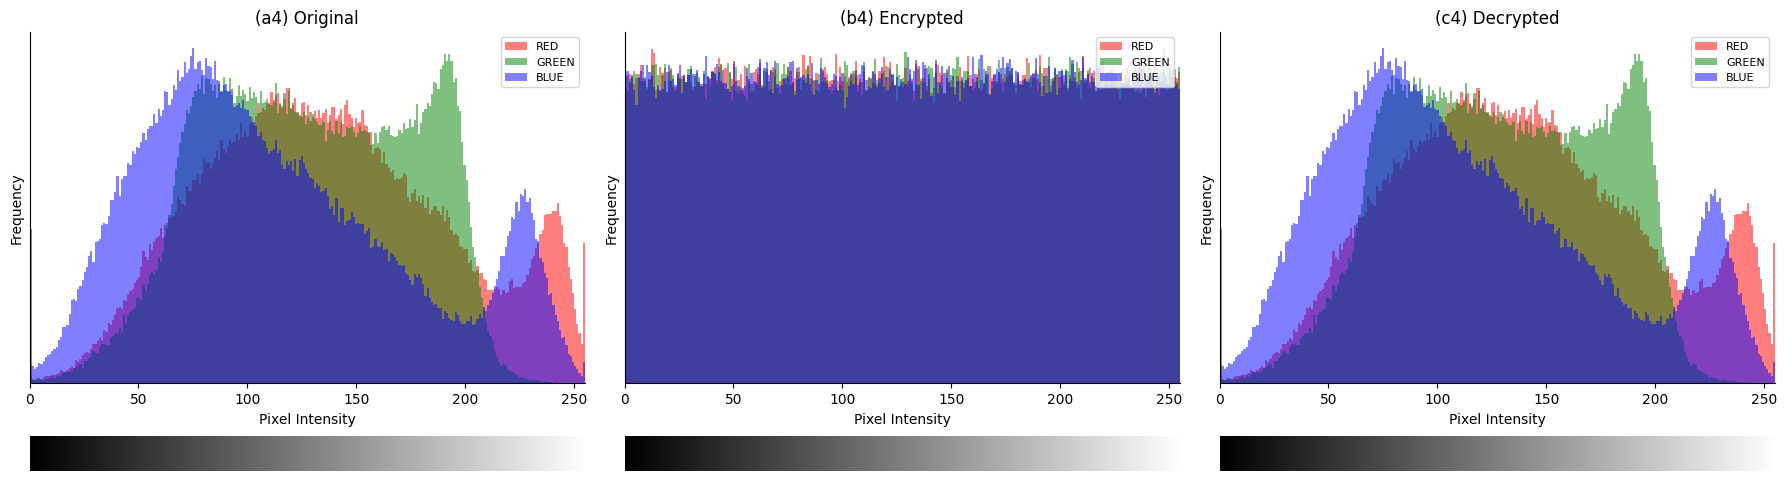

In [32]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- Load Images (as RGB) ---
orig_img = np.array(Image.open(plainImg).convert("RGB"))
cipher_img = np.array(Image.open(encryImg).convert("RGB"))
decrypted_img = np.array(Image.open("decrypted_baboon.png").convert("RGB"))

images = [orig_img, cipher_img, decrypted_img]
titles = ["(a4) Original", "(b4) Encrypted", "(c4) Decrypted"]
colors = ['red', 'green', 'blue']

# --- Create Figure ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]
    img = images[i]

    for ch, color in enumerate(colors):
        channel_data = img[:, :, ch].ravel()
        ax.hist(channel_data, bins=256, range=(0, 255), color=color, alpha=0.5, label=f'{color.upper()}')

    ax.set_xlim(0, 255)
    ax.set_xticks([0, 50, 100, 150, 200, 250])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=8, loc='upper right')

    # Add grayscale bar below
    gray_bar = np.tile(np.arange(256, dtype=np.uint8), (20, 1))
    inset = ax.inset_axes([0, -0.25, 1, 0.1])
    inset.imshow(gray_bar, cmap='gray', aspect='auto')
    inset.axis('off')

# --- Layout & Save ---
plt.tight_layout()
plt.savefig("histograms_color_image_with_labels.png", dpi=300, bbox_inches='tight')
plt.show()


In [31]:
# ##correlation Diagram

# plainImg = r"C:\Users\User\Desktop\Images\512x512 grayscale\Color-image-baboon-and-its-gray-valued-representation-used-as-transparency.png"

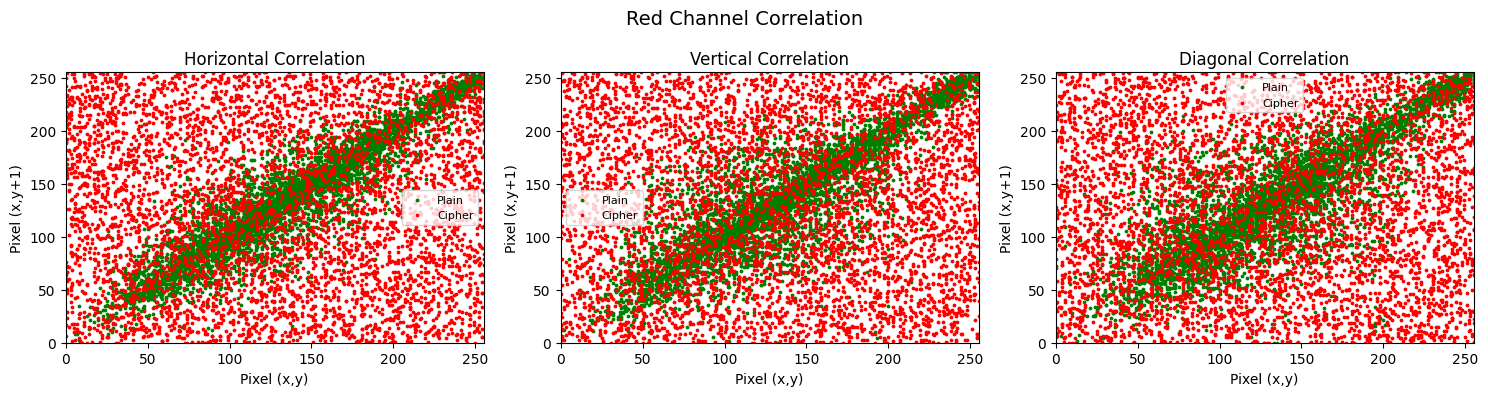

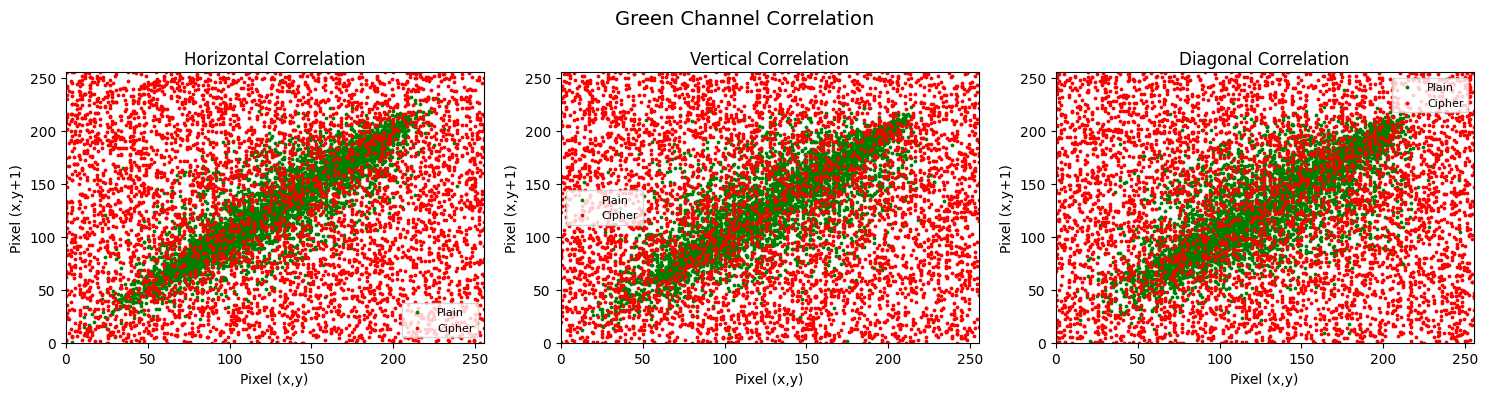

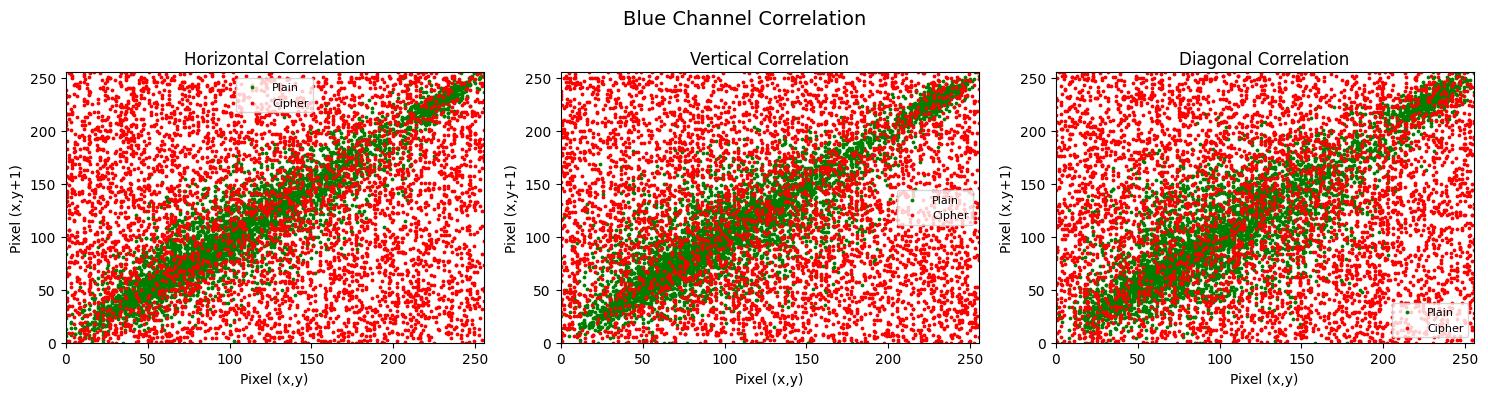

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# --- Load images as color ---
plain_img = np.array(Image.open(plainImg).convert("RGB"))
cipher_img = np.array(Image.open("encrypted_baboon.png").convert("RGB"))

# --- Extract pixel pairs by direction ---
def get_pixel_pairs_color(img, direction='horizontal', num_samples=5000, channel=0):
    h, w, _ = img.shape
    x_vals, y_vals = [], []
    for _ in range(num_samples):
        if direction == 'horizontal':
            i = random.randint(0, h - 1)
            j = random.randint(0, w - 2)
            x, y = img[i, j, channel], img[i, j + 1, channel]
        elif direction == 'vertical':
            i = random.randint(0, h - 2)
            j = random.randint(0, w - 1)
            x, y = img[i, j, channel], img[i + 1, j, channel]
        elif direction == 'diagonal':
            i = random.randint(0, h - 2)
            j = random.randint(0, w - 2)
            x, y = img[i, j, channel], img[i + 1, j + 1, channel]
        x_vals.append(x)
        y_vals.append(y)
    return np.array(x_vals), np.array(y_vals)

# --- Plot correlation for R/G/B channels ---
channels = ['Red', 'Green', 'Blue']
directions = ['horizontal', 'vertical', 'diagonal']

for ch in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'{channels[ch]} Channel Correlation', fontsize=14)
    
    for i, direction in enumerate(directions):
        px_plain_x, px_plain_y = get_pixel_pairs_color(plain_img, direction=direction, channel=ch)
        px_cipher_x, px_cipher_y = get_pixel_pairs_color(cipher_img, direction=direction, channel=ch)

        axes[i].scatter(px_plain_x, px_plain_y, s=3, c='green', label='Plain')
        axes[i].scatter(px_cipher_x, px_cipher_y, s=3, c='red', label='Cipher')
        axes[i].set_xlim(0, 255)
        axes[i].set_ylim(0, 255)
        axes[i].set_title(f"{direction.capitalize()} Correlation")
        axes[i].set_xlabel("Pixel (x,y)")
        axes[i].set_ylabel("Pixel (x,y+1)")
        axes[i].legend(fontsize=8)

    plt.tight_layout()
    plt.show()


In [34]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error
from PIL import Image
import numpy as np

def compare_color_images(original_path, decrypted_path):
    # Load as RGB
    original = np.array(Image.open(original_path).convert("RGB"), dtype=np.uint8)
    decrypted = np.array(Image.open(decrypted_path).convert("RGB"), dtype=np.uint8)

    # Compute MSE for each channel, then average
    mse_vals = []
    psnr_vals = []
    ssim_val = ssim(original, decrypted, data_range=255, channel_axis=2)

    for i, channel in enumerate(['R', 'G', 'B']):
        orig_ch = original[:, :, i].flatten()
        decr_ch = decrypted[:, :, i].flatten()

        mse = mean_squared_error(orig_ch, decr_ch)
        mse_vals.append(mse)

        psnr_ch = psnr(original[:, :, i], decrypted[:, :, i], data_range=255)
        psnr_vals.append(psnr_ch)

    # Print results
    print("📊 Color Image Comparison Results:")
    for i, ch in enumerate(['R', 'G', 'B']):
        print(f"{ch}-Channel MSE:   {mse_vals[i]:.4f}")
        print(f"{ch}-Channel PSNR:  {psnr_vals[i]:.2f} dB")
    print(f"Multichannel SSIM: {ssim_val:.4f}")


In [36]:
compare_color_images(r"C:\Users\User\Desktop\Images\color Image\512x512\Baboon.png", "decrypted_baboon.png")


📊 Color Image Comparison Results:
R-Channel MSE:   0.0000
R-Channel PSNR:  inf dB
G-Channel MSE:   0.0000
G-Channel PSNR:  inf dB
B-Channel MSE:   0.0000
B-Channel PSNR:  inf dB
Multichannel SSIM: 1.0000


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [38]:
from PIL import Image
import numpy as np

# Load original and decrypted images in RGB mode
original = np.array(Image.open(
    r"C:\Users\User\Desktop\Images\color Image\512x512\Baboon.png"
).convert("RGB"), dtype=np.uint8)
decrypted_resized = Image.open("decrypted_baboon.png").convert("RGB").resize(original.shape[1::-1])
decrypted = np.array(decrypted_resized, dtype=np.uint8)

# Compute absolute pixel differences
diff = np.abs(original.astype(int) - decrypted.astype(int))

# Results
max_pixel_diff = np.max(diff)
total_mismatched_pixels = np.sum(np.any(diff > 0, axis=2))  # mismatch in any channel

print("Max pixel diff (any channel):", max_pixel_diff)
print("Total mismatched pixels (any channel):", total_mismatched_pixels)


Max pixel diff (any channel): 0
Total mismatched pixels (any channel): 0


In [39]:
import numpy as np
import matplotlib.pyplot as plt
def henon_bifurcation_diagram(a_vals, b=0.3, x0=0.1, y0=0.1, n_iter=500, discard=100):
    x_vals, a_range = [], []

    for a in a_vals:
        x, y = x0, y0
        for i in range(n_iter):
            x_new = 1 - a * x**2 + y
            y_new = b * x
            x, y = x_new, y_new

            # Only record after discarding transient states
            if i >= discard:
                if abs(x) < 10:  # Optional: avoid extreme outliers
                    x_vals.append(x)
                    a_range.append(a)
    return a_range, x_vals


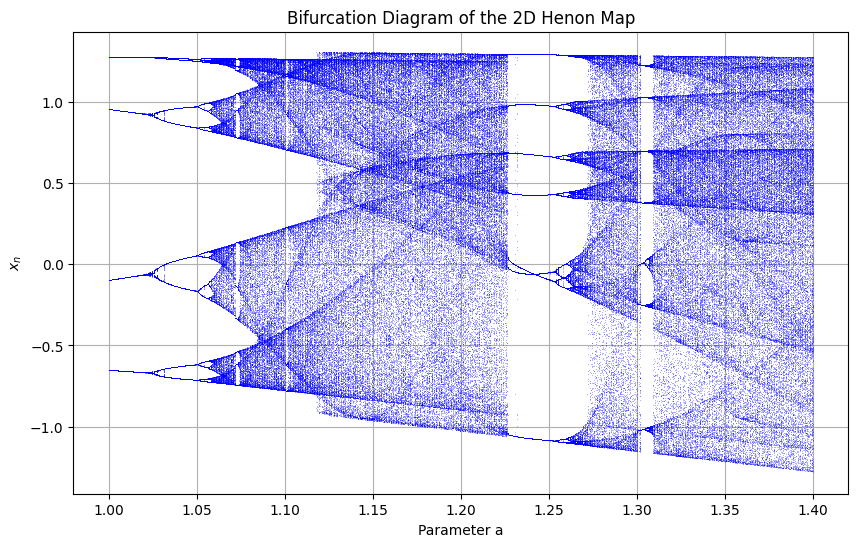

In [40]:
a_values = np.linspace(1.0, 1.4, 1000)
a_range, x_values = henon_bifurcation_diagram(a_values)

plt.figure(figsize=(10, 6))
plt.plot(a_range, x_values, ',b', alpha=0.3)
plt.xlabel("Parameter a")
plt.ylabel("$x_n$")
plt.title("Bifurcation Diagram of the 2D Henon Map")
plt.grid(True)
plt.show()


In [49]:
from PIL import Image
import numpy as np

# --- Load image in RGB (color) mode ---
original_image = Image.open(plainImg).convert("RGB")
original_array = np.array(original_image)

# --- Slightly modify one pixel in one channel (e.g., red channel) ---
modified_array = original_array.copy()
r, g, b = modified_array[0, 0]
modified_pixel = [np.uint8((int(r) + 1) % 256), g, b]
modified_array[0, 0] = modified_pixel

# --- Save both original and modified versions to temporary files ---
Image.fromarray(original_array).save("temp_original.png")
Image.fromarray(modified_array).save("temp_modified.png")

# --- Encrypt both using the same encryption function ---
cipher1 = encrypt_image_variable_sbox_chunked(
    "temp_original.png", "cipher1.png", key,
    sbox_interval=1, x0_mask=0.5, r_mask=3.99
)
cipher2 = encrypt_image_variable_sbox_chunked(
    "temp_modified.png", "cipher2.png", key,
    sbox_interval=1, x0_mask=0.5, r_mask=3.99
)

def entropy(image_array):
    """
    Entropy (bits) of a grayscale or color-channel uint8 array.
    """
    arr = image_array.astype(np.uint8, copy=False)
    hist = np.bincount(arr.ravel(), minlength=256).astype(np.float64)
    p = hist / hist.sum()
    p = p[p > 0]
    return float(-np.sum(p * np.log2(p)))

def security_analysis_color1(cipher_path_1, cipher_path_2):
    cipher1 = np.array(Image.open(cipher_path_1).convert("RGB"))
    cipher2 = np.array(Image.open(cipher_path_2).convert("RGB"))

    if cipher1.shape != cipher2.shape:
        raise ValueError("Image dimensions must match.")

    # --- NPCR & UACI per channel ---
    npcr_total = 0.0
    uaci_total = 0.0
    for c, name in enumerate(["R","G","B"]):
        diff = cipher1[:, :, c] != cipher2[:, :, c]
        npcr = np.sum(diff) / diff.size * 100.0

        abs_diff = np.abs(cipher1[:, :, c].astype(np.int16) - cipher2[:, :, c].astype(np.int16))
        uaci = np.sum(abs_diff) / (cipher1[:, :, c].size * 255.0) * 100.0

        print(f"Channel {name} — NPCR: {npcr:.2f} %, UACI: {uaci:.2f} %")
        npcr_total += npcr
        uaci_total += uaci

    print(f"\nAverage NPCR: {npcr_total / 3:.2f} %")
    print(f"Average UACI: {uaci_total / 3:.2f} %")

    # --- Entropy (per-channel + pooled) ---
    ent_c1 = [entropy(cipher1[:, :, c]) for c in range(3)]
    ent_c2 = [entropy(cipher2[:, :, c]) for c in range(3)]
    ent_c1_pooled = entropy(cipher1.reshape(-1))
    ent_c2_pooled = entropy(cipher2.reshape(-1))

    print("\n— Entropy (bits) —")
    print(f"Cipher1: R {ent_c1[0]:.4f}, G {ent_c1[1]:.4f}, B {ent_c1[2]:.4f}, pooled {ent_c1_pooled:.4f}")
    print(f"Cipher2: R {ent_c2[0]:.4f}, G {ent_c2[1]:.4f}, B {ent_c2[2]:.4f}, pooled {ent_c2_pooled:.4f}")

    # Redundancy (distance from 8 bits)
    red_c1 = [8.0 - x for x in ent_c1]
    red_c2 = [8.0 - x for x in ent_c2]
    print(f"\nRedundancy (8 - entropy) — Cipher1: R {red_c1[0]:.4f}, G {red_c1[1]:.4f}, B {red_c1[2]:.4f}, pooled {8.0 - ent_c1_pooled:.4f}")
    print(f"Redundancy (8 - entropy) — Cipher2: R {red_c2[0]:.4f}, G {red_c2[1]:.4f}, B {red_c2[2]:.4f}, pooled {8.0 - ent_c2_pooled:.4f}")

    return {
        "npcr_avg": npcr_total / 3.0,
        "uaci_avg": uaci_total / 3.0,
        "entropy": {
            "cipher1": {"R": ent_c1[0], "G": ent_c1[1], "B": ent_c1[2], "pooled": ent_c1_pooled},
            "cipher2": {"R": ent_c2[0], "G": ent_c2[1], "B": ent_c2[2], "pooled": ent_c2_pooled},
        },
        "redundancy": {
            "cipher1": {"R": red_c1[0], "G": red_c1[1], "B": red_c1[2], "pooled": 8.0 - ent_c1_pooled},
            "cipher2": {"R": red_c2[0], "G": red_c2[1], "B": red_c2[2], "pooled": 8.0 - ent_c2_pooled},
        }
    }

# Example run:
# results = security_analysis_color1("cipher1.png", "cipher2.png")


In [48]:
# from PIL import Image
# import numpy as np

# # --- Load image in RGB (color) mode ---
# original_image = Image.open(plainImg).convert("RGB")
# original_array = np.array(original_image)

# # --- Slightly modify one pixel in one channel (e.g., red channel) ---
# modified_array = original_array.copy()
# r, g, b = modified_array[0, 0]
# modified_pixel = [np.uint8((int(r) + 1) % 256), g, b]
# modified_array[0, 0] = modified_pixel

# # --- Save both original and modified versions to temporary files ---
# Image.fromarray(original_array).save("temp_original.png")
# Image.fromarray(modified_array).save("temp_modified.png")

# # --- Encrypt both using the same encryption function ---
# cipher1 = encrypt_image_variable_sbox_chunked(
#     "temp_original.png", "cipher1.png", key,
#     sbox_interval=1, x0_mask=0.5, r_mask=3.99
# )

# cipher2 = encrypt_image_variable_sbox_chunked(
#     "temp_modified.png", "cipher2.png", key,
#     sbox_interval=1, x0_mask=0.5, r_mask=3.99
# )

# def entropy(image_array):
#     """
#     Compute entropy (bits) of a grayscale or color channel image.
#     """
#     hist, _ = np.histogram(image_array.ravel(), bins=256, range=(0, 256))
#     p = hist / np.sum(hist)
#     p = p[p > 0]
#     return -np.sum(p * np.log2(p))

# def security_analysis_color1(cipher_path_1, cipher_path_2):
#     cipher1 = np.array(Image.open(cipher_path_1).convert("RGB"))
#     cipher2 = np.array(Image.open(cipher_path_2).convert("RGB"))

#     if cipher1.shape != cipher2.shape:
#         raise ValueError("Image dimensions must match.")

#     # NPCR & UACI
#     npcr_total = 0.0
#     uaci_total = 0.0
#     for c in range(3):  # R, G, B
#         diff = cipher1[:, :, c] != cipher2[:, :, c]
#         npcr = np.sum(diff) / diff.size * 100.0

#         abs_diff = np.abs(cipher1[:, :, c].astype(np.int16) - cipher2[:, :, c].astype(np.int16))
#         uaci = np.sum(abs_diff) / (cipher1[:, :, c].size * 255.0) * 100.0

#         print(f"Channel {['R','G','B'][c]} — NPCR: {npcr:.2f} %, UACI: {uaci:.2f} %")
#         npcr_total += npcr
#         uaci_total += uaci

#     print(f"\nAverage NPCR: {npcr_total / 3:.2f} %")
#     print(f"Average UACI: {uaci_total / 3:.2f} %")

#     # Entropy
#     ent_c1 = [entropy(cipher1[:, :, c]) for c in range(3)]
#     ent_c2 = [entropy(cipher2[:, :, c]) for c in range(3)]

#     print("\n— Entropy (bits) —")
#     print(f"Cipher1: R {ent_c1[0]:.4f}, G {ent_c1[1]:.4f}, B {ent_c1[2]:.4f}")
#     print(f"Cipher2: R {ent_c2[0]:.4f}, G {ent_c2[1]:.4f}, B {ent_c2[2]:.4f}")
#     print(f"\nAverage Cipher1 Entropy: {np.mean(ent_c1):.4f} bits")
#     print(f"Average Cipher2 Entropy: {np.mean(ent_c2):.4f} bits")

In [50]:
security_analysis_color1("cipher1.png", "cipher2.png")


Channel R — NPCR: 99.60 %, UACI: 33.38 %
Channel G — NPCR: 99.59 %, UACI: 33.45 %
Channel B — NPCR: 99.61 %, UACI: 33.50 %

Average NPCR: 99.60 %
Average UACI: 33.44 %

— Entropy (bits) —
Cipher1: R 7.9993, G 7.9994, B 7.9992, pooled 7.9998
Cipher2: R 7.9993, G 7.9992, B 7.9994, pooled 7.9998

Redundancy (8 - entropy) — Cipher1: R 0.0007, G 0.0006, B 0.0008, pooled 0.0002
Redundancy (8 - entropy) — Cipher2: R 0.0007, G 0.0008, B 0.0006, pooled 0.0002


{'npcr_avg': np.float64(99.60110982259114),
 'uaci_avg': np.float64(33.44392614426956),
 'entropy': {'cipher1': {'R': 7.999338965895707,
   'G': 7.9993524468587704,
   'B': 7.999171114562429,
   'pooled': 7.999755904995825},
  'cipher2': {'R': 7.999320174938276,
   'G': 7.999232206882609,
   'B': 7.999356904750629,
   'pooled': 7.999752555897288}},
 'redundancy': {'cipher1': {'R': 0.0006610341042927459,
   'G': 0.000647553141229551,
   'B': 0.0008288854375706478,
   'pooled': 0.00024409500417466035},
  'cipher2': {'R': 0.0006798250617237045,
   'G': 0.0007677931173910579,
   'B': 0.0006430952493712283,
   'pooled': 0.0002474441027118246}}}

In [51]:
import numpy as np

# --- Logistic Map-based Permutation Generator ---
def logistic_permutation(length, x0=0.7, r=3.99):
    """Generate a permutation index array using a logistic map."""
    seq = np.zeros(length)
    x = x0
    for i in range(length):
        x = r * x * (1 - x)
        seq[i] = x
    perm = np.argsort(seq)
    return perm

# --- Apply Row and Column Permutation to Color Image ---
def apply_logistic_shuffle_color(image_array, x0=0.7, r=3.99):
    """
    Apply logistic map-based row and column permutation to a color image.

    Args:
        image_array (np.ndarray): RGB image array of shape (H, W, 3)
        x0 (float): initial condition for logistic map
        r (float): control parameter for logistic map

    Returns:
        shuffled (np.ndarray): shuffled RGB image
        row_perm (np.ndarray): permutation indices for rows
        col_perm (np.ndarray): permutation indices for columns
    """
    shuffled = image_array.copy()
    h, w = image_array.shape[:2]

    row_perm = logistic_permutation(h, x0, r)
    col_perm = logistic_permutation(w, (x0 + 0.123456) % 1, r)

    shuffled = shuffled[row_perm, :, :]
    shuffled = shuffled[:, col_perm, :]

    return shuffled, row_perm, col_perm

# --- Unshuffle (Inverse Permutation) ---
def inverse_permutation(perm):
    """Compute the inverse of a permutation."""
    inverse = np.empty_like(perm)
    for i, p in enumerate(perm):
        inverse[p] = i
    return inverse

def undo_logistic_shuffle_color(shuffled_array, row_perm, col_perm):
    """
    Undo logistic map-based shuffling for color images.

    Args:
        shuffled_array (np.ndarray): shuffled RGB image of shape (H, W, 3)
        row_perm (np.ndarray): row permutation used
        col_perm (np.ndarray): column permutation used

    Returns:
        unshuffled (np.ndarray): restored RGB image
    """
    unshuffled = shuffled_array.copy()
    inv_row = inverse_permutation(row_perm)
    inv_col = inverse_permutation(col_perm)

    unshuffled = unshuffled[inv_row, :, :]
    unshuffled = unshuffled[:, inv_col, :]

    return unshuffled


In [54]:
from PIL import Image
import numpy as np

# Load encrypted color image in RGB mode
img = np.array(Image.open(encryImg).convert("RGB"))

# Apply logistic shuffling for color image
shuffled_img1, row_perm, col_perm = apply_logistic_shuffle_color(img)

# Save the shuffled image
Image.fromarray(shuffled_img1).save("shuffled_encrypted_baboon_color.png")


In [55]:
from PIL import Image
import numpy as np

# Load the shuffled encrypted color image
shuffled_img = np.array(Image.open("shuffled_encrypted_baboon_color.png").convert("RGB"))

# Undo logistic shuffle for color image
restored_img = undo_logistic_shuffle_color(shuffled_img, row_perm, col_perm)

# Save the restored (unshuffled) image
Image.fromarray(restored_img).save("unshuffled_restored_baboon_color.png")



In [56]:
import numpy as np

def correlation_analysis_color(img):
    """
    Compute horizontal, vertical, and diagonal correlation coefficients for each RGB channel.
    """
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Input image must be a color (RGB) image.")

    img = img.astype(np.int16)
    h, w, _ = img.shape

    def corr(a, b):
        return np.corrcoef(a.flatten(), b.flatten())[0, 1]

    channels = ['Red', 'Green', 'Blue']
    for c in range(3):
        channel_data = img[:, :, c]

        horizontal = corr(channel_data[:, :-1], channel_data[:, 1:])
        vertical = corr(channel_data[:-1, :], channel_data[1:, :])
        diagonal = corr(channel_data[:-1, :-1], channel_data[1:, 1:])

        print(f"\n🔹 Channel: {channels[c]}")
        print(f" Horizontal: {horizontal:.4f}")
        print(f" Vertical:   {vertical:.4f}")
        print(f" Diagonal:   {diagonal:.4f}")


In [57]:
from PIL import Image

color_img = shuffled_img1
correlation_analysis_color(color_img)


🔹 Channel: Red
 Horizontal: -0.0040
 Vertical:   -0.0024
 Diagonal:   -0.0005

🔹 Channel: Green
 Horizontal: -0.0006
 Vertical:   -0.0015
 Diagonal:   0.0015

🔹 Channel: Blue
 Horizontal: -0.0014
 Vertical:   -0.0008
 Diagonal:   0.0008


In [58]:
from PIL import Image

color_img = np.array(Image.open("encrypted_baboon.png").convert("RGB"))
correlation_analysis_color(color_img)



🔹 Channel: Red
 Horizontal: -0.0039
 Vertical:   0.0007
 Diagonal:   0.0014

🔹 Channel: Green
 Horizontal: -0.0017
 Vertical:   0.0040
 Diagonal:   -0.0001

🔹 Channel: Blue
 Horizontal: 0.0007
 Vertical:   -0.0024
 Diagonal:   0.0007


In [348]:
# !pip install pandas